This notebook shows how to setup a new project, train a keypoint-MoSeq model and visualize the resulting syllables. You can load keypoint tracking results from SLEAP, DeepLabCut, or using your own custom format. We provide an [example DeepLabCut dataset](https://drive.google.com/drive/folders/1UNHQ_XCQEKLPPSjGspRopWBj6-YNDV6G?usp=share_link) that can be used for the tutorial.

# Project setup
Create a new project directory with a keypoint-MoSeq `config.yml` file.

In [1]:
import keypoint_moseq as kpms

bodyparts = ['nose','neck','anus','chest','rfoot','lfoot','rhand','lhand','tip']

skeleton=[
    ['neck', 'chest'],
    ['chest', 'anus'],
    ['nose', 'neck'],
    ['lhand', 'chest'],
    ['lfoot', 'anus'],
    ['rhand', 'chest'],
    ['rfoot', 'anus'],
    ['anus', 'tip']]

project_dir = r'G:\다른 컴퓨터\BGlab\git\kp_moseq\keypoint-moseq\project\AmD\dataset3'
video_dir= []

kpms.setup_project(
    project_dir,
    video_dir=video_dir,
    bodyparts=bodyparts,
    skeleton=skeleton, overwrite=True)

config = lambda: kpms.load_config(project_dir)

In [1]:
# load existed project (run this code after creating a project)

import keypoint_moseq as kpms

project_dir = r'H:\공유 드라이브\Broad X ACTNOVA\kp-moseq\trial2_without_nose_tip'
video_dir= []
config = lambda: kpms.load_config(project_dir)

## Edit the config file

The config can be edited in a text editor or using the function `kpms.update_config`, as shown below. In general, the following parameters should be specified for each project:

- `bodyparts` (name of each keypoint; automatically imported from SLEAP/DeepLabCut)
- `use_bodyparts` (subset of bodyparts to use for modeling, set to all bodyparts by default; for mice we recommend excluding the tail)
- `anterior_bodyparts` and `posterior_bodyparts` (used for rotational alignment)
- `video_dir` (directory with videos of each experiment)

Edit the config as follows for the [example DeepLabCut dataset](https://drive.google.com/drive/folders/1UNHQ_XCQEKLPPSjGspRopWBj6-YNDV6G?usp=share_link):

In [2]:
kpms.update_config(
    project_dir,
    video_dir=video_dir,
    anterior_bodyparts=['neck'],
    posterior_bodyparts=['anus'],
    use_bodyparts=['neck','anus','chest','rfoot','lfoot','rhand','lhand']
)

## Load data

The code below shows how to load keypoint detections from DeepLabCut. To load other formats, replace `'deeplabcut'` in the example with one of `'sleap', 'anipose', 'sleap-anipose', 'nwb'`. For other formats, see the [FAQ](https://keypoint-moseq.readthedocs.io/en/latest/FAQs.html#loading-keypoint-tracking-data).

In [3]:
import os

# source path 설정
source_path = r'G:\다른 컴퓨터\BGlab\AVATAR-AmD\dataset3'

# 파일 이름 리스트
file_names = [
    'ko_s1d54_111.csv',
    'ko_s1d54_122.csv',
    'ko_s1d58_131.csv',
    'ko_s1d61_113.csv',
    'ko_s1d61_121.csv',
    'ko_s1d65_123.csv',
    'ko_s1d65_141.csv',
    'ko_s1d68_112.csv',
    'ko_s3d50_312.csv',
    'ko_s3d50_324.csv',
    'ko_s3d54_332.csv',
    'ko_s3d57_322.csv',
    'ko_s3d57_336.csv',
    'ko_s3d64_323.csv',
    'wt_s1d54_142.csv',
    'wt_s1d54_151.csv',
    'wt_s1d58_152.csv',
    'wt_s1d61_142.csv',
    'wt_s1d61_151.csv',
    'wt_s1d65_142.csv',
    'wt_s1d65_152.csv',
    'wt_s1d68_151.csv',
    'wt_s3d50_321.csv',
    'wt_s3d50_337.csv',
    'wt_s3d54_311.csv',
    'wt_s3d57_313.csv',
    'wt_s3d61_331.csv',
    'wt_s3d64_325.csv'
    ]

# 파일 경로 리스트 생성
file_data_paths = [os.path.join(source_path, file_name) for file_name in file_names]


In [4]:
# load data from AVATAR .csv file
keypoint_data_path = file_data_paths # can be a file, a directory, or a list of files

coordinates, bodyparts = kpms.load_keypoints_AVATAR(keypoint_data_path, path_in_name=False, remove_extension=True)

# format data for modeling
data, metadata = kpms.format_data(coordinates, confidences=None, **config())

Loading keypoints: 100%|██████████| 28/28 [00:00<00:00, 35.62it/s]


## Calibration

The purpose of calibration is to learn the relationship between error and keypoint confidence scores. The resulting regression coefficients (`slope` and `intercept`) are used during modeling to set the noise prior on a per-frame, per-keypoint basis. One can also adjust the `confidence_threshold` parameter at this step, which is used to define outlier keypoints for PCA and model initialization. **This step can be skipped for the demo data** since the config already includes suitable regression coefficients.

- Run the cell below. A widget should appear with a video frame on the left.
    - *If the widget doesn't render, try using jupyter lab instead of jupyter notebook*
    
- Annotate each frame with the correct location of the labeled bodypart
    - Left click to specify the correct location - an "X" should appear.
    - Use the arrow buttons to annotate additional frames.
    - Each annotation adds a point to the right-hand scatter plot. 
    - Continue until the regression line stabilizes.
   
- At any point, adjust the confidence threshold by clicking on the scatter plot.

- Use the "save" button to update the config and store your annotations to disk.

In [ ]:
#kpms.noise_calibration(project_dir, coordinates, confidences, **config())

## Fit PCA

Run the cell below to fit a PCA model to aligned and centered keypoint coordinates.

- The model is saved to ``{project_dir}/pca.p`` and can be reloaded using ``kpms.load_pca``. 
- Two plots are generated: a cumulative [scree plot](https://en.wikipedia.org/wiki/Scree_plot) and a depiction of each PC, where translucent nodes/edges represent the mean pose and opaque nodes/edges represent a perturbation in the direction of the PC. 
- After fitting, edit `latent_dimension` in the config. This determines the dimension of the pose trajectory used to fit keypoint-MoSeq. A good heuristic is the number of dimensions needed to explain 90% of variance, or 10 dimensions - whichever is lower.  

>=90.0% of variance exlained by 10 components.


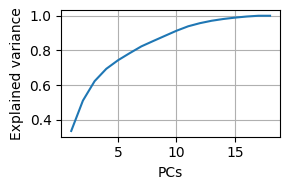

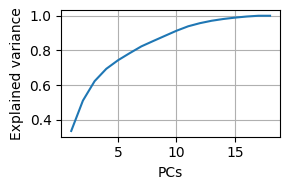

In [5]:
pca = kpms.fit_pca(**data, **config())
kpms.save_pca(pca, project_dir)

kpms.print_dims_to_explain_variance(pca, 0.9)
kpms.plot_scree(pca, project_dir=project_dir)
#kpms.plot_pcs(pca, project_dir=project_dir, **config())

In [11]:
pca_3d = kpms.plot_pcs_3D(pca, project_dir=project_dir, **config())

TypeError: plot_pcs_3D() got an unexpected keyword argument 'bodyparts'

In [8]:
# use the following to load an already existing PCA model
pca = kpms.load_pca(project_dir)

Trying to unpickle estimator PCA from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

In [6]:
kpms.update_config(project_dir, latent_dim=10)

# Model fitting

Fitting a keypoint-MoSeq model involves:
1. **Initialization:** Auto-regressive (AR) parameters and syllable sequences are randomly initialized using pose trajectories from PCA.
2. **Fitting an AR-HMM:** The AR parameters, transition probabilities and syllable sequences are iteratively updated through Gibbs sampling. 
3. **Fitting the full model:** All parameters, including both the AR-HMM as well as centroid, heading, noise-estimates and continuous latent states (i.e. pose trajectories) are iteratively updated through Gibbs sampling. This step is especially useful for noisy data.
4. **Extracting model results:** The learned states of the model are parsed and saved to disk for vizualization and downstream analysis.
4. **[Optional] Applying the trained model:** The learned model parameters can be used to infer a syllable sequences for additional data.

## Setting kappa

Most users will need to adjust the **kappa** hyperparameter to achieve the desired distribution of syllable durations. For this tutorial we chose kappa values that yielded a median syllable duration of 400ms (12 frames). Most users will need to tune kappa to their particular dataset. Higher values of kappa lead to longer syllables. **You will need to pick two kappas: one for AR-HMM fitting and one for the full model.**
- We recommend iteratively updating kappa and refitting the model until the target syllable time-scale is attained.  
- Model fitting can be stopped at any time by interrupting the kernel, and then restarted with a new kappa value.
- The full model will generally require a lower value of kappa to yield the same target syllable durations. 
- To adjust the value of kappa in the model, use `kpms.update_hypparams` as shown below. Note that this command only changes kappa in the model dictionary, not the kappa value in the config file. The value in the config is only used during model initialization.

## Initialization

In [7]:
# initialize the model
model = kpms.init_model(data, pca=pca, **config())

In [8]:
# optionally modify kappa
model = kpms.update_hypparams(model, kappa=1e9)

## Fitting an AR-HMM

In addition to fitting an AR-HMM, the function below:
- generates a name for the model and a corresponding directory in `project_dir`
- saves a checkpoint every 25 iterations from which fitting can be restarted
- plots the progress of fitting every 25 iterations, including
    - the distributions of syllable frequencies and durations for the most recent iteration
    - the change in median syllable duration across fitting iterations
    - a sample of the syllable sequence across iterations in a random window

Outputs will be saved to G:\다른 컴퓨터\BGlab\git\kp_moseq\keypoint-
moseq\project\AmD\dataset3\2024_06_20-23_15_08


 20%|██████▋                           | 20/101 [02:14<09:15,  6.86s/it]

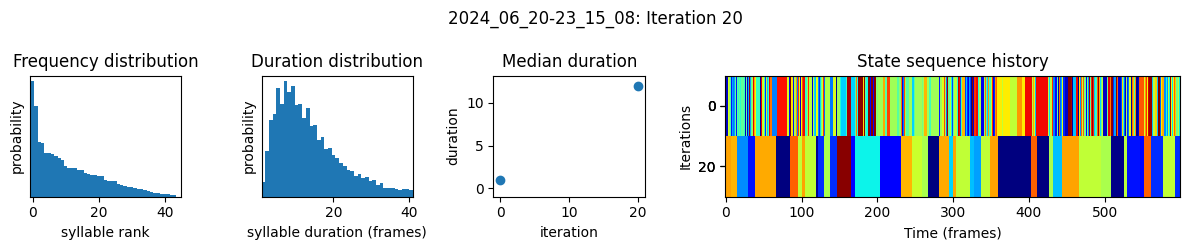

 40%|█████████████▍                    | 40/101 [04:42<07:09,  7.04s/it]

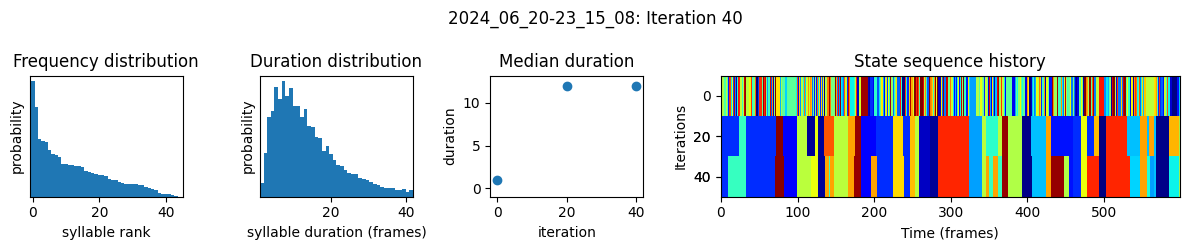

 59%|████████████████████▏             | 60/101 [07:09<04:44,  6.94s/it]

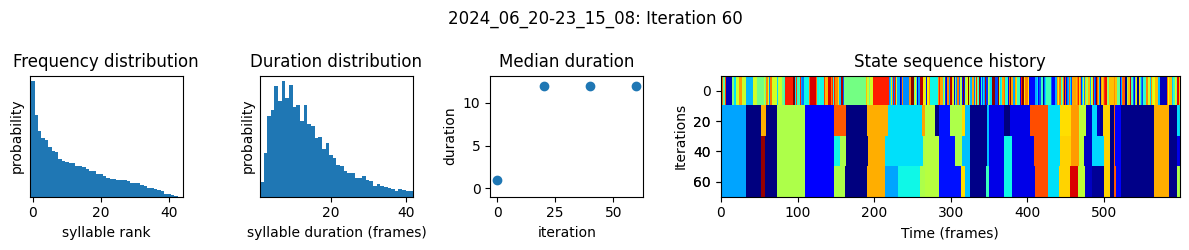

 79%|██████████████████████████▉       | 80/101 [09:36<02:29,  7.11s/it]

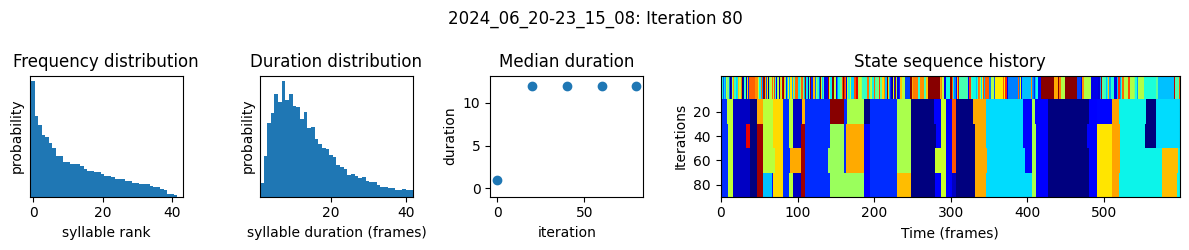

 99%|████████████████████████████████▋| 100/101 [12:02<00:06,  7.00s/it]

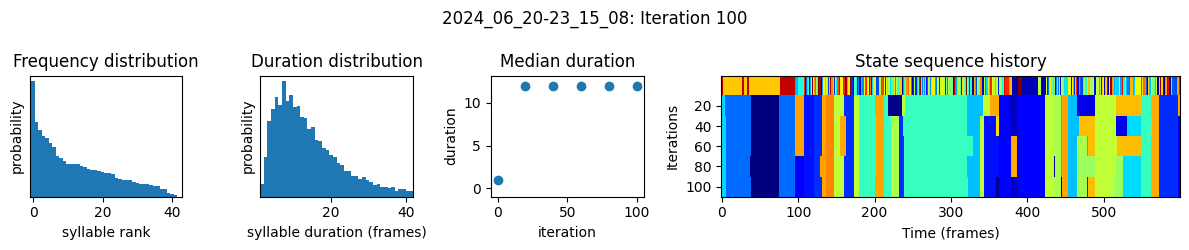

100%|█████████████████████████████████| 101/101 [12:13<00:00,  7.26s/it]


In [9]:
num_ar_iters = 100

model, model_name = kpms.fit_model(
    model=model, data=data, metadata=metadata, project_dir=project_dir,
    ar_only=True, num_iters=num_ar_iters, save_every_n_iters = 20)

## Fitting the full model

The following code fits a full keypoint-MoSeq model using the results of AR-HMM fitting for initialization. If using your own data, you may need to try a few values of kappa at this step. 

In [16]:
# This codes are for Partially serializing the computations because of the out of memory error
from jax_moseq.utils import set_mixed_map_iters
set_mixed_map_iters(4)

In [18]:
model_name = '2024_03_27-21_14_34'

# num_ar_iters = 0

In [15]:
# load model checkpoint
model, data, metadata, current_iter = kpms.load_checkpoint(
    project_dir, model_name, iteration=200)

Outputs will be saved to G:\다른 컴퓨터\BGlab\git\kp_moseq\keypoint-
moseq\project\AmD\dataset3\2024_06_20-23_15_08


 10%|███▏                            | 20/201 [07:22<1:05:38, 21.76s/it]

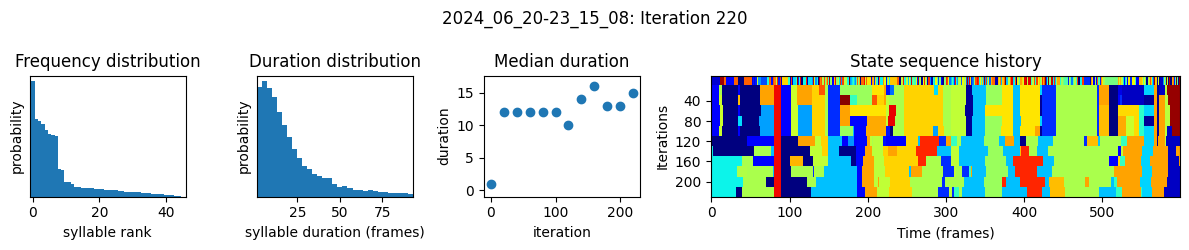

 20%|██████▊                           | 40/201 [14:45<58:36, 21.84s/it]

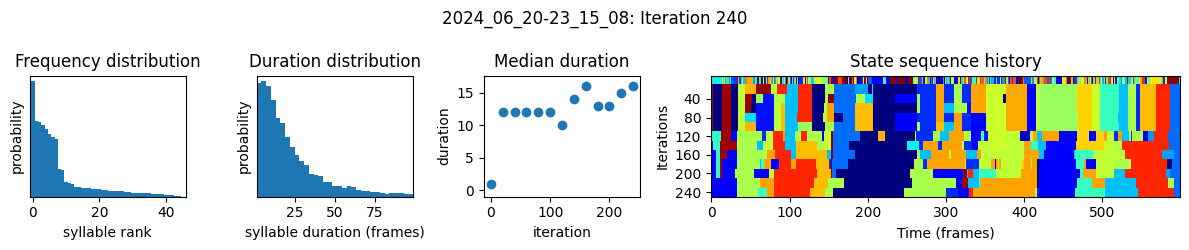

 30%|██████████▏                       | 60/201 [22:12<51:23, 21.87s/it]

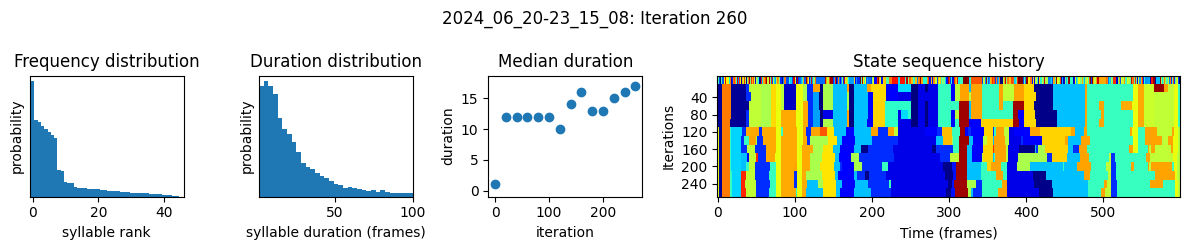

 40%|█████████████▌                    | 80/201 [29:39<44:22, 22.00s/it]

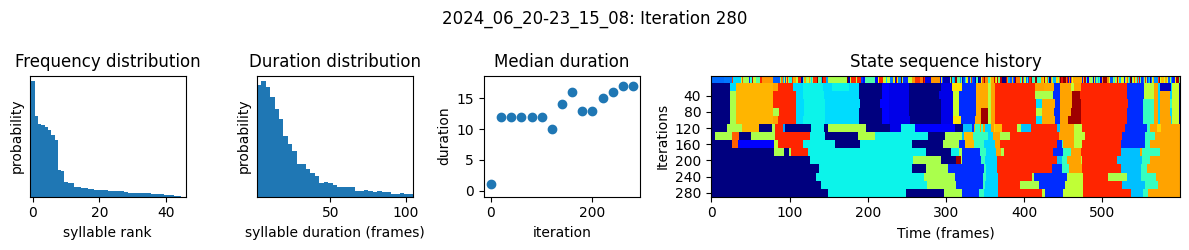

 50%|████████████████▍                | 100/201 [37:05<36:53, 21.92s/it]

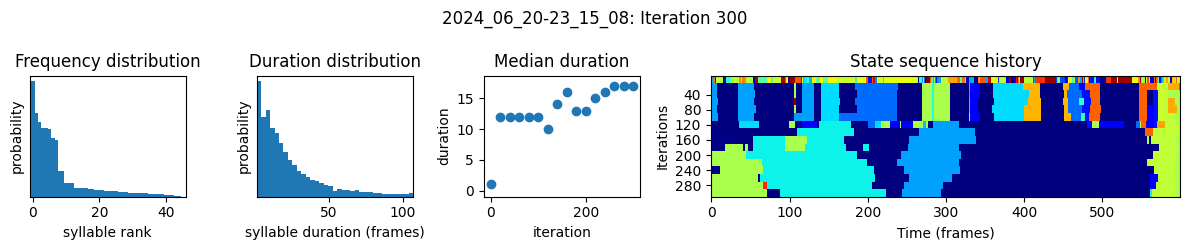

 60%|███████████████████▋             | 120/201 [44:31<29:20, 21.73s/it]

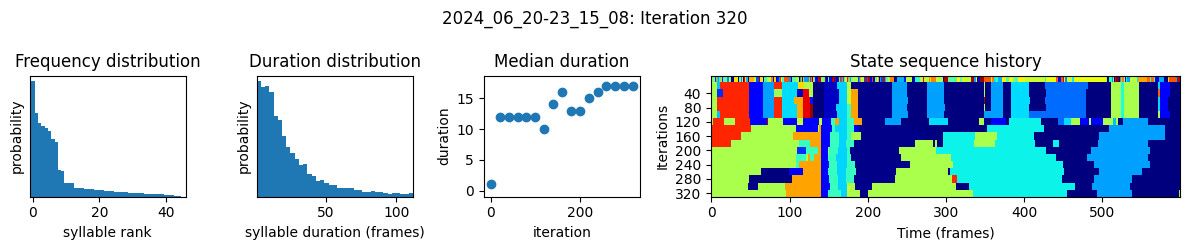

 70%|██████████████████████▉          | 140/201 [51:56<22:03, 21.69s/it]

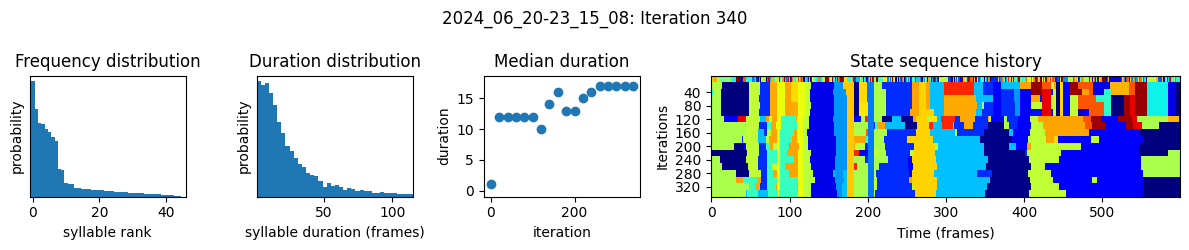

 80%|██████████████████████████▎      | 160/201 [59:25<14:54, 21.82s/it]

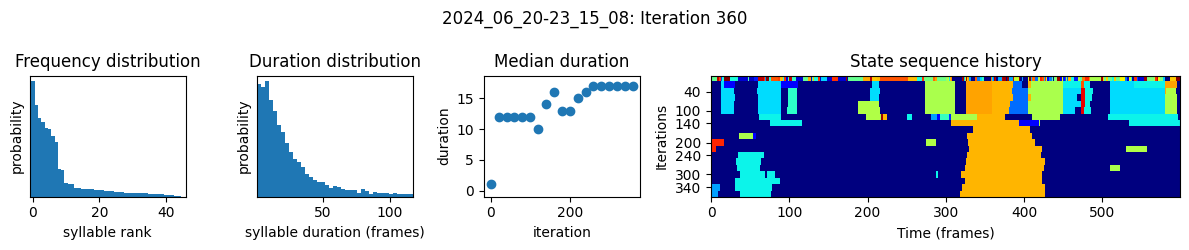

 90%|███████████████████████████▊   | 180/201 [1:06:50<07:36, 21.74s/it]

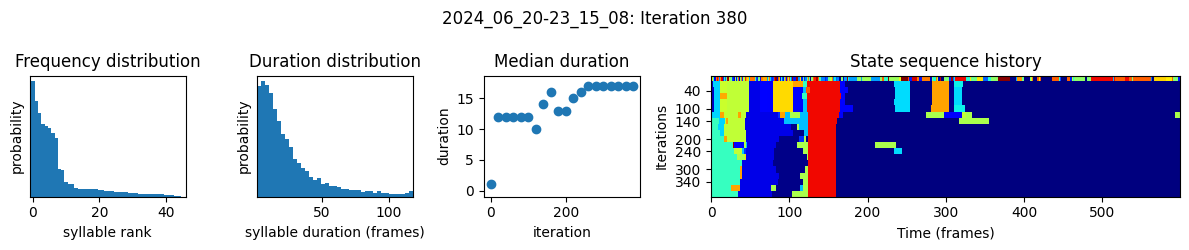

100%|██████████████████████████████▊| 200/201 [1:16:44<00:21, 21.92s/it]

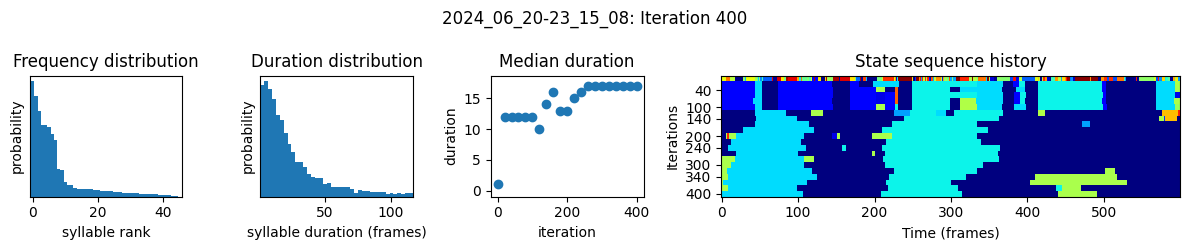

100%|███████████████████████████████| 201/201 [1:19:40<00:00, 23.78s/it]


In [16]:
#model, data, metadata, current_iter = kpms.load_checkpoint(
# project_dir, model_name)

# modify kappa to maintain the desired syllable time-scale
model = kpms.update_hypparams(model, kappa=5e3)

# run fitting for an additional 200 iters
model = kpms.fit_model(
    model, data, metadata, project_dir, model_name, ar_only=False, 
    start_iter=current_iter, num_iters=current_iter+200, save_every_n_iters =20, parallel_message_passing=False)[0]

## Sort syllables by frequency

Permute the states and parameters of a saved checkpoint so that syllables are labeled in order of frequency (i.e. so that `0` is the most frequent, `1` is the second most, and so on). 

In [17]:
# modify a saved checkpoint so syllables are ordered by frequency
kpms.reindex_syllables_in_checkpoint(project_dir, model_name)

Reindexing: 100%|███████████| 21/21 [03:00<00:00,  8.60s/model snapshot]


array([55, 41, 58, 31, 73, 17,  0, 12,  1, 86, 63, 14, 57, 36, 72, 56, 68,
        2, 96,  9, 28, 34, 70, 97, 33, 11, 71, 59,  6, 90, 67, 23, 40, 27,
       80, 53, 13, 16, 66, 81, 38, 48, 26, 98, 89, 93, 87, 19, 29,  8, 64,
       21, 79, 62, 47, 25, 15, 18,  4, 49, 65, 83, 77, 51, 52, 69,  5, 91,
        7, 85, 10, 82, 78, 75, 74, 42, 99, 30, 35, 24, 44, 45, 50, 46, 61,
       32, 22, 37, 76, 20, 92, 94, 95,  3, 84, 43, 88, 54, 60, 39],
      dtype=int64)

```{warning}
Reindexing is only applied to the checkpoint file. Therefore, if you perform this step after extracting the modeling results or generating vizualizations, then those steps must be repeated.
```

## Extract model results

Parse the modeling results and save them to `{project_dir}/{model_name}/results.h5`. The results are stored as follows, and can be reloaded at a later time using `kpms.load_results`. Check the docs for an [in-depth explanation of the modeling results](https://keypoint-moseq.readthedocs.io/en/latest/FAQs.html#interpreting-model-outputs).
```
    results.h5
    ├──recording_name1
    │  ├──syllable      # syllable labels (z)
    │  ├──latent_state  # inferred low-dim pose state (x)
    │  ├──centroid      # inferred centroid (v)
    │  └──heading       # inferred heading (h)
    ⋮
```

In [18]:
# load the most recent model checkpoint
model_name = '2024_06_20-23_15_08'
#model = kpms.load_checkpoint(project_dir, model_name)[0]
pca = kpms.load_pca(project_dir)
model, data, metadata, current_iter = kpms.load_checkpoint(project_dir, model_name)

# extract results
results = kpms.extract_results(model, metadata, project_dir, model_name)

Saved results to G:\다른 컴퓨터\BGlab\git\kp_moseq\keypoint-
moseq\project\AmD\dataset3\2024_06_20-23_15_08\results.h5


In [11]:
# from keypoint_moseq.io import save_hdf5
# save_hdf5(r'C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset3\trainset1\2023_08_23-15_27_30\results.h5', results)

### [Optional] Save results to csv

After extracting to an h5 file, the results can also be saved as csv files. A separate file will be created for each recording and saved to `{project_dir}/{model_name}/results/`. 

In [25]:
# optionally save results as csv
kpms.save_results_as_csv(results, project_dir, model_name)

Saving to csv: 100%|████████████████████| 28/28 [00:02<00:00, 11.38it/s]


## Apply to new data

The code below shows how to apply a trained model to new data. This is useful if you have performed new experiments and would like to maintain an existing set of syllables. The results for the new experiments will be added to the existing `results.h5` file. **This step is optional and can be skipped if you do not have new data to add**.

In [1]:
# run this code after creating a project

import keypoint_moseq as kpms

project_dir = r'G:\다른 컴퓨터\BGlab\git\kp_moseq\keypoint-moseq\project\AmD\dataset3'
video_dir= []
config = lambda: kpms.load_config(project_dir)

# load saved model checkpoint
model_name = '2024_06_20-23_15_08'
model = kpms.load_checkpoint(project_dir, model_name)[0]
# pca = kpms.load_pca(project_dir)

In [3]:
import os
input_folder = r'G:\다른 컴퓨터\BGlab\AVATAR-AmD\dataset3'
data_all_paths = [os.path.join(input_folder, file) for file in os.listdir(input_folder) if file.endswith('.csv')]

In [4]:
## Junesu - For many folders, batch analysis

# load new data (e.g. from deeplabcut)
new_data = data_all_paths

chunk_size = 6  # The size of the small list you want to divide
for i in range(0, len(new_data), chunk_size):
    batch = new_data[i:i + chunk_size]
    coordinates, bodyparts = kpms.load_keypoints_AVATAR(batch, path_in_name=False, remove_extension=True)
    data, metadata = kpms.format_data(coordinates, confidences=None, **config())
    results = kpms.apply_model(model, data, metadata, project_dir, model_name, num_iters=60,**config())

    # optionally rerun `save_results_as_csv` to export the new results
    kpms.save_results_as_csv(results, project_dir, model_name)

Applying model: 100%|███████████████████| 60/60 [06:25<00:00,  6.42s/it]


Saved results to G:\다른 컴퓨터\BGlab\git\kp_moseq\keypoint-
moseq\project\AmD\dataset3\2024_06_20-23_15_08\results.h5


Applying model: 100%|███████████████████| 60/60 [06:10<00:00,  6.17s/it]


Saved results to G:\다른 컴퓨터\BGlab\git\kp_moseq\keypoint-
moseq\project\AmD\dataset3\2024_06_20-23_15_08\results.h5


Applying model: 100%|███████████████████| 60/60 [06:06<00:00,  6.10s/it]


Saved results to G:\다른 컴퓨터\BGlab\git\kp_moseq\keypoint-
moseq\project\AmD\dataset3\2024_06_20-23_15_08\results.h5


Applying model: 100%|███████████████████| 60/60 [06:06<00:00,  6.11s/it]


Saved results to G:\다른 컴퓨터\BGlab\git\kp_moseq\keypoint-
moseq\project\AmD\dataset3\2024_06_20-23_15_08\results.h5


Applying model: 100%|███████████████████| 60/60 [06:05<00:00,  6.09s/it]


Saved results to G:\다른 컴퓨터\BGlab\git\kp_moseq\keypoint-
moseq\project\AmD\dataset3\2024_06_20-23_15_08\results.h5


Applying model: 100%|███████████████████| 60/60 [06:12<00:00,  6.20s/it]


Saved results to G:\다른 컴퓨터\BGlab\git\kp_moseq\keypoint-
moseq\project\AmD\dataset3\2024_06_20-23_15_08\results.h5


Applying model: 100%|███████████████████| 60/60 [06:13<00:00,  6.23s/it]


Saved results to G:\다른 컴퓨터\BGlab\git\kp_moseq\keypoint-
moseq\project\AmD\dataset3\2024_06_20-23_15_08\results.h5


Applying model: 100%|███████████████████| 60/60 [06:12<00:00,  6.21s/it]


Saved results to G:\다른 컴퓨터\BGlab\git\kp_moseq\keypoint-
moseq\project\AmD\dataset3\2024_06_20-23_15_08\results.h5


Applying model: 100%|███████████████████| 60/60 [06:09<00:00,  6.16s/it]


Saved results to G:\다른 컴퓨터\BGlab\git\kp_moseq\keypoint-
moseq\project\AmD\dataset3\2024_06_20-23_15_08\results.h5


Applying model: 100%|███████████████████| 60/60 [06:11<00:00,  6.19s/it]


Saved results to G:\다른 컴퓨터\BGlab\git\kp_moseq\keypoint-
moseq\project\AmD\dataset3\2024_06_20-23_15_08\results.h5


Applying model: 100%|███████████████████| 60/60 [06:13<00:00,  6.22s/it]


Saved results to G:\다른 컴퓨터\BGlab\git\kp_moseq\keypoint-
moseq\project\AmD\dataset3\2024_06_20-23_15_08\results.h5


Applying model: 100%|███████████████████| 60/60 [06:12<00:00,  6.21s/it]


Saved results to G:\다른 컴퓨터\BGlab\git\kp_moseq\keypoint-
moseq\project\AmD\dataset3\2024_06_20-23_15_08\results.h5


Applying model: 100%|███████████████████| 60/60 [06:12<00:00,  6.22s/it]


Saved results to G:\다른 컴퓨터\BGlab\git\kp_moseq\keypoint-
moseq\project\AmD\dataset3\2024_06_20-23_15_08\results.h5


Applying model: 100%|███████████████████| 60/60 [06:10<00:00,  6.18s/it]


Saved results to G:\다른 컴퓨터\BGlab\git\kp_moseq\keypoint-
moseq\project\AmD\dataset3\2024_06_20-23_15_08\results.h5


Applying model: 100%|███████████████████| 60/60 [06:09<00:00,  6.17s/it]


Saved results to G:\다른 컴퓨터\BGlab\git\kp_moseq\keypoint-
moseq\project\AmD\dataset3\2024_06_20-23_15_08\results.h5


Applying model: 100%|███████████████████| 60/60 [06:05<00:00,  6.09s/it]


Saved results to G:\다른 컴퓨터\BGlab\git\kp_moseq\keypoint-
moseq\project\AmD\dataset3\2024_06_20-23_15_08\results.h5


Applying model: 100%|███████████████████| 60/60 [06:09<00:00,  6.15s/it]


Saved results to G:\다른 컴퓨터\BGlab\git\kp_moseq\keypoint-
moseq\project\AmD\dataset3\2024_06_20-23_15_08\results.h5


Saving to csv: 100%|██████████████████████| 6/6 [00:00<00:00,  8.92it/s]


# Visualization

## Trajectory plots
Generate plots showing the median trajectory of poses associated with each given syllable. 

In [3]:
import keypoint_moseq as kpms
import os

project_dir = r'C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\AmD\dataset2'
model_name = '2024_06_16-01_26_57'
config = lambda: kpms.load_config(project_dir)
results = kpms.load_results(project_dir, model_name)

# load keypoints
input_folder = r'T:\2.실험데이터\AVATAR-AmD_이성민학생\dataset2'
data_all_paths = [os.path.join(input_folder, file) for file in os.listdir(input_folder) if file.endswith('.csv')]
coordinates, bodyparts = kpms.load_keypoints_AVATAR(data_all_paths, path_in_name=False, remove_extension=True)

min_frequency = 0.005
fps = 20

Loading keypoints: 100%|██████████| 102/102 [00:04<00:00, 23.10it/s]


Loading keypoints: 100%|██████████| 102/102 [00:33<00:00,  3.06it/s]


Saving trajectory plots to G:\다른 컴퓨터\BGlab\git\kp_moseq\keypoint-moseq\project\AmD\dataset2\2024_06_16-01_26_57\trajectory_plots


Generating trajectory plots: 100%|██████| 19/19 [00:06<00:00,  2.82it/s]


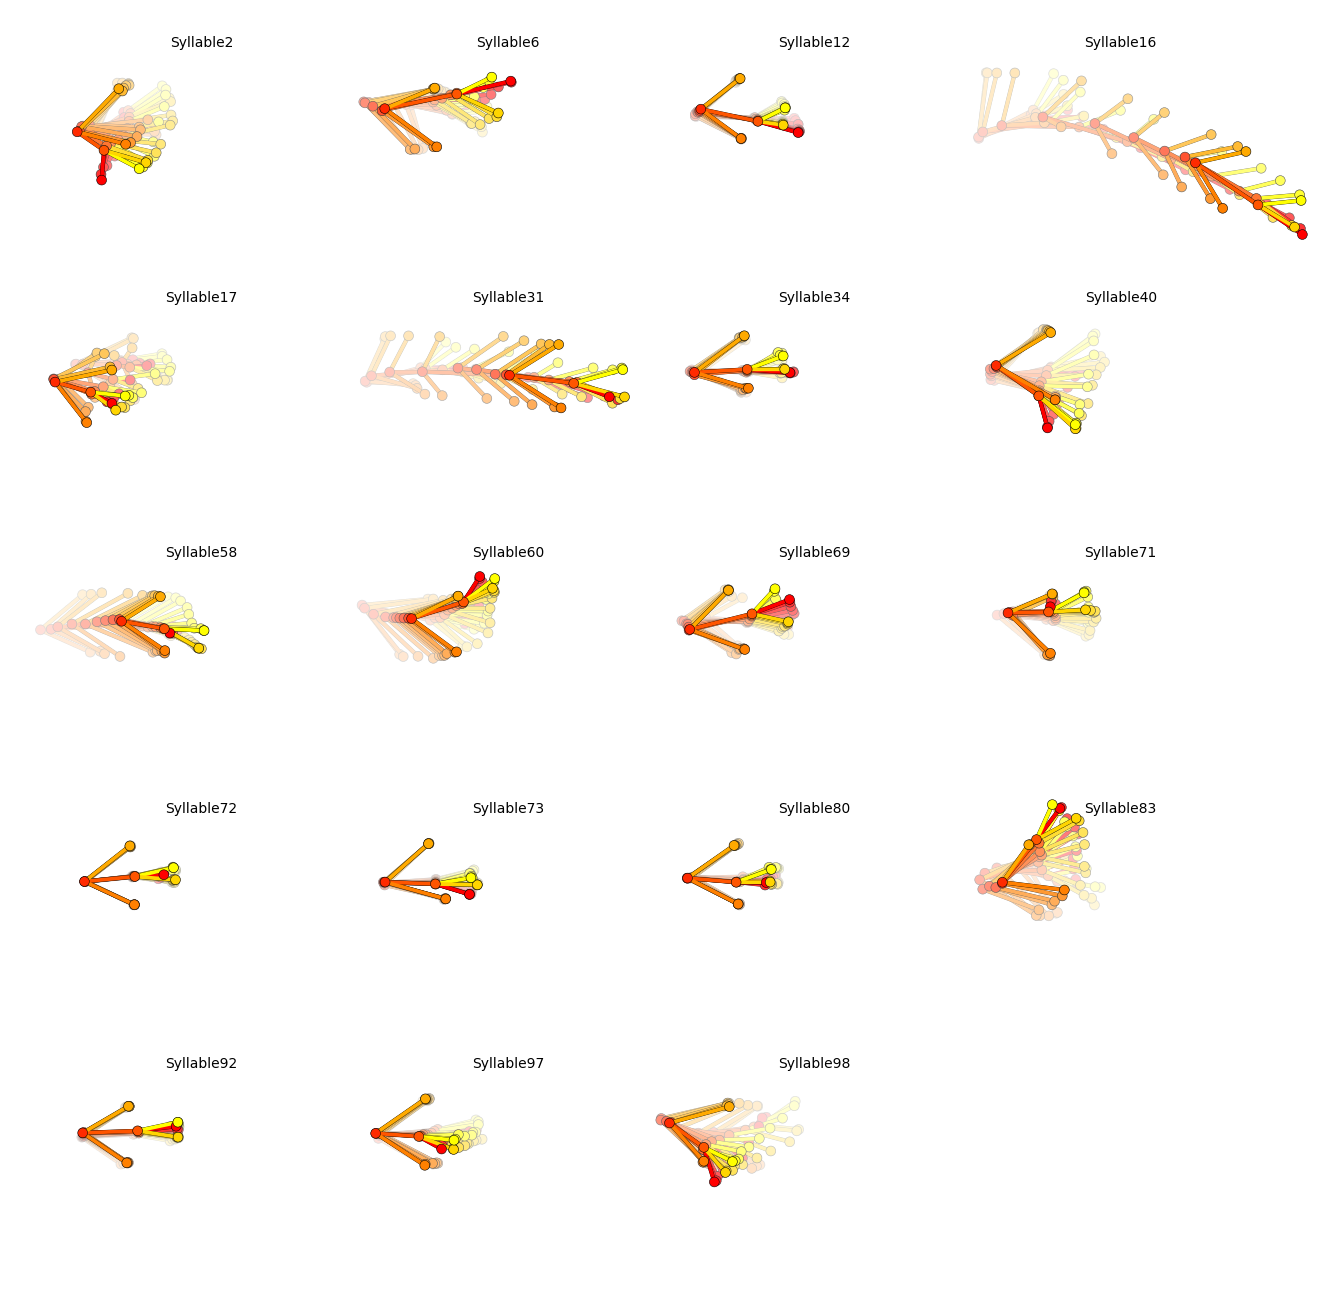

Generating trajectory plots: 100%|██████| 19/19 [00:08<00:00,  2.32it/s]


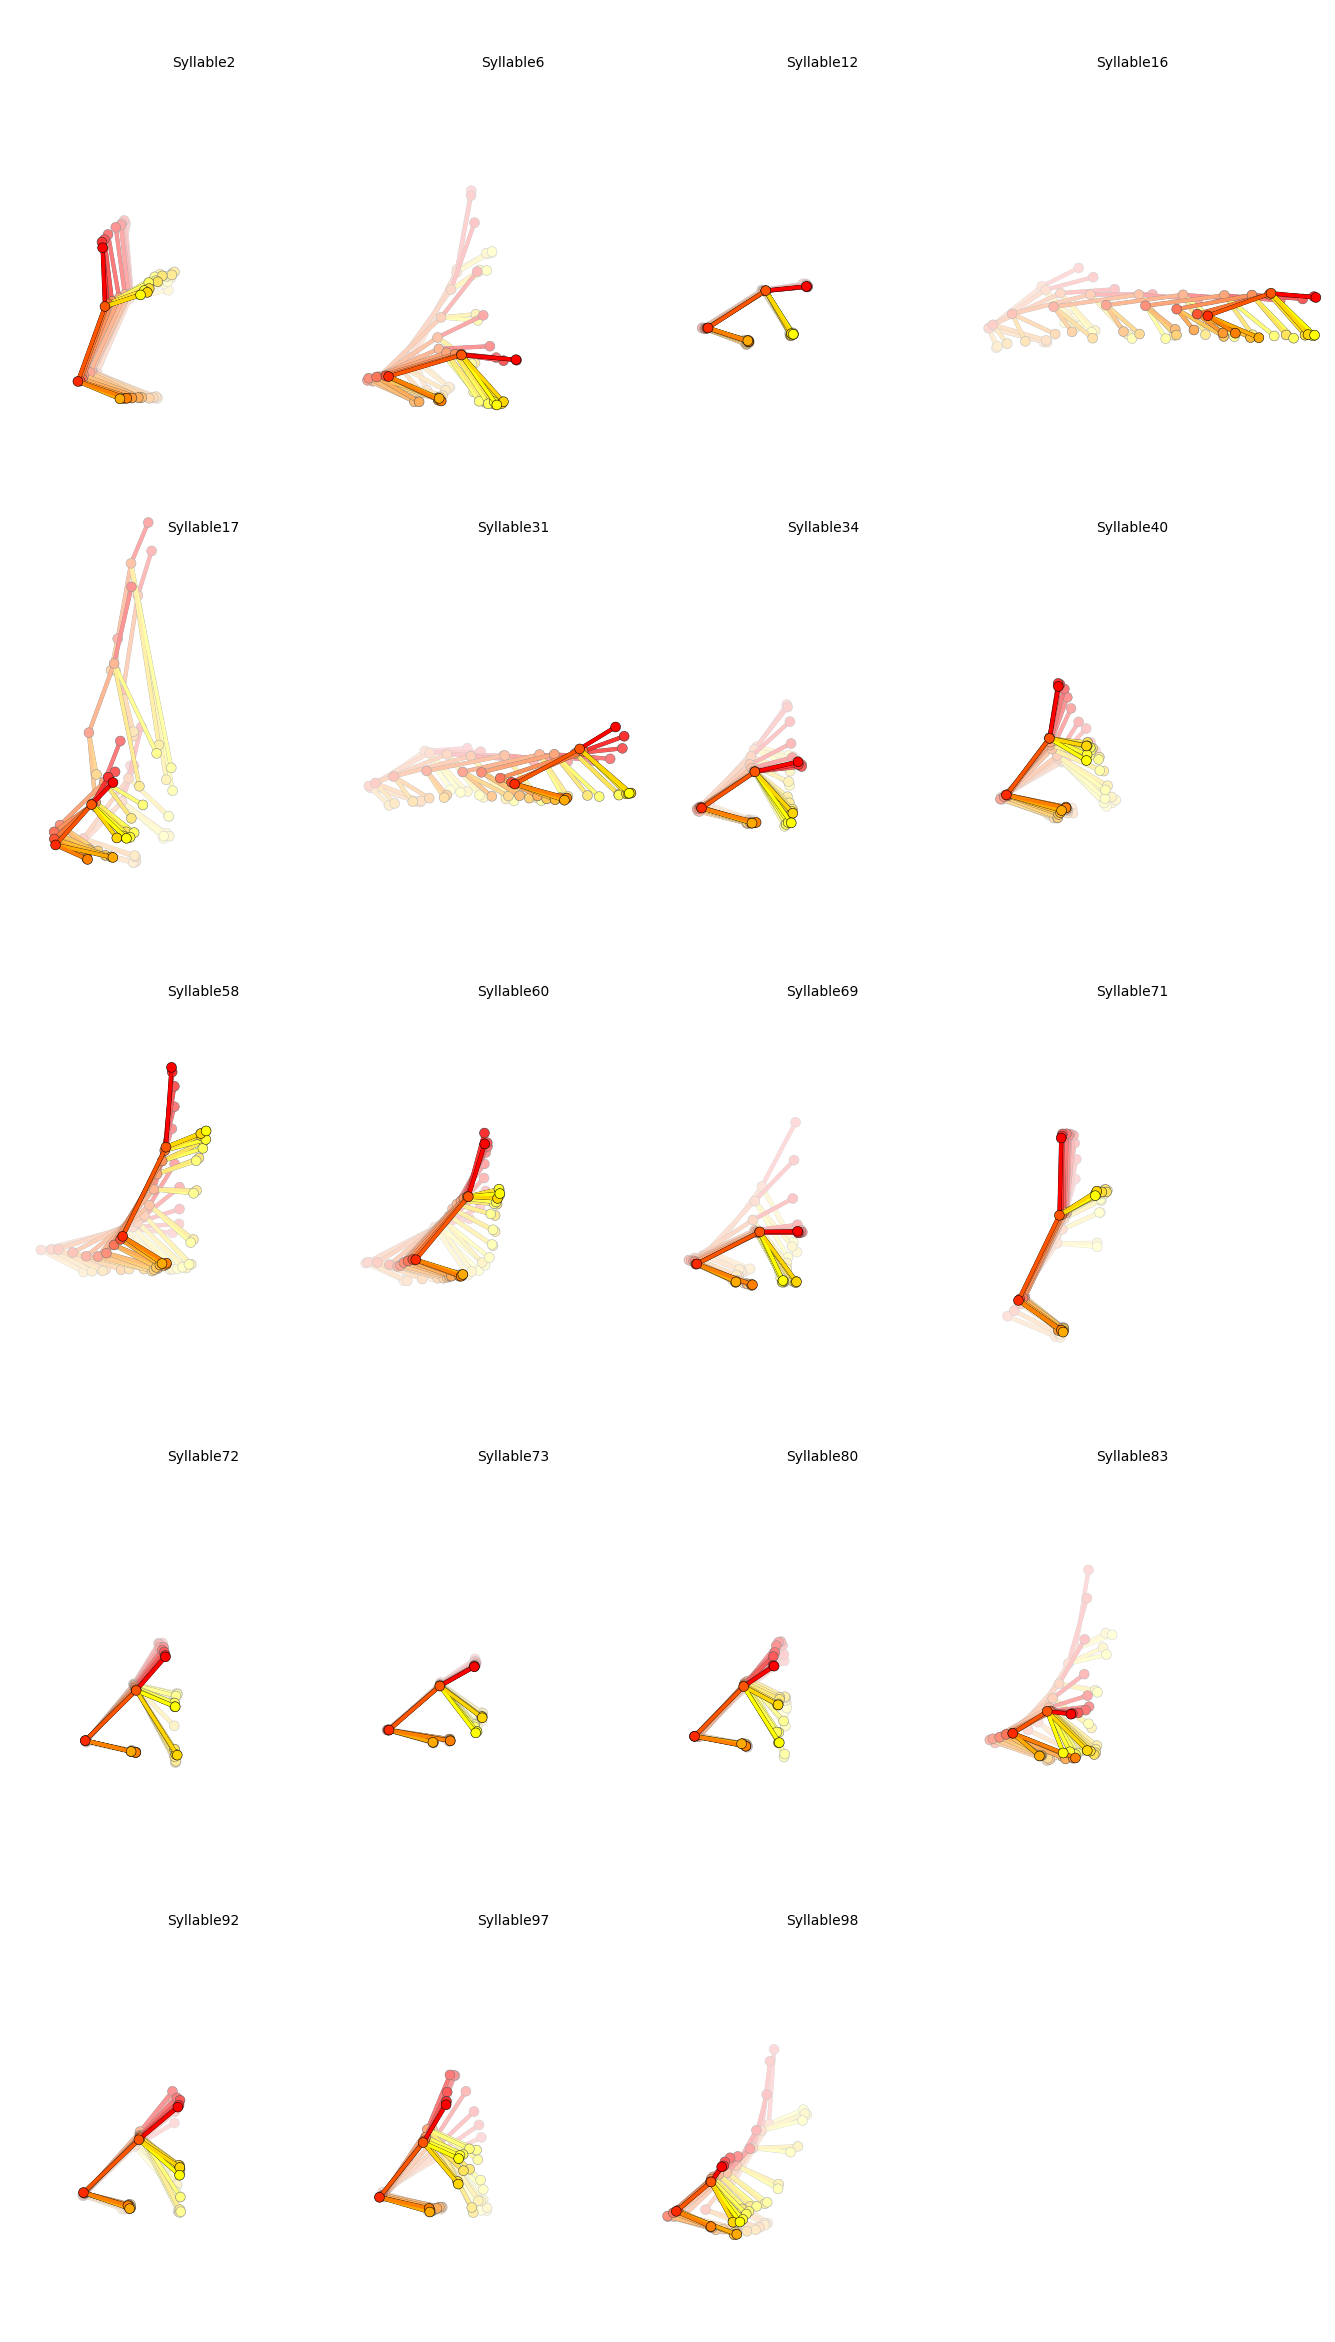

Saved interactive trajectories plot to G:\다른 컴퓨터\BGlab\git\kp_moseq\keypoint-moseq\project\AmD\dataset2\2024_06_16-01_26_57\trajectory_plots\all_trajectories.html


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [40]:
# Users occasionally find that the trajectory plot and grid movie for a given syllable don’t match up. 

## Why do my trajectory plots and grid movies disagree?
# For example the animal might turn left in the trajectory plot but not consistently do so in the grid movie. 
# Similarly, trajectory plots can occasionally change dramatically when a trained keypoint-MoSeq model is applied to new data. 
# In most cases, these inconsistencies are caused by density sampling of syllable instances. 
# Turning this feature off may result in more stable trajectory plots.
# kpms.generate_trajectory_plots(..., density_sample=False)
import keypoint_moseq as kpms

project_dir = r'G:\다른 컴퓨터\BGlab\git\kp_moseq\keypoint-moseq\project\AmD\dataset2'
model_name = '2024_06_16-01_26_57'
config = lambda: kpms.load_config(project_dir)
results = kpms.load_results(project_dir, model_name)

# load keypoints
input_folder = r'G:\다른 컴퓨터\BGlab\AVATAR-AmD\dataset2'
data_all_paths = [os.path.join(input_folder, file) for file in os.listdir(input_folder) if file.endswith('.csv')]
coordinates, bodyparts = kpms.load_keypoints_AVATAR(data_all_paths, path_in_name=False, remove_extension=True)

min_frequency = 0.005
fps = 20

kpms.generate_trajectory_plots(coordinates, results, project_dir, model_name, min_frequency = min_frequency, fps=fps, **config())

### Trajectory plots for a part of results dataset

In [37]:
start_order = 46
number_of_orders = 12

end_order = start_order + number_of_orders
dataset = data_all_paths[start_order:end_order]
coordinates, bodyparts = kpms.load_keypoints_AVATAR(dataset, path_in_name=False, remove_extension=True)

Loading keypoints:   0%|          | 0/12 [00:00<?, ?it/s]

Loading keypoints: 100%|██████████| 12/12 [00:23<00:00,  1.94s/it]


In [38]:
# Create a dictionary called results_subgroup by extracting only the values in results that have the same keys as the key in the 'coordinates' variable
results_subgroup = {key: results[key] for key in coordinates.keys()}

# print keys of results
print(results_subgroup.keys())

dict_keys(['SETD1A_WT_M_39_#10', 'SETD1A_WT_M_41_#1', 'SETD1A_WT_M_41_#2', 'SETD1A_WT_M_41_#9', 'SETD1A_WT_M_43_#3', 'SETD1A_WT_M_43_#4', 'SETD1A_WT_M_43_#6', 'SETD1A_WT_M_43_#7', 'SETD1A_WT_M_43_#8', 'SETD1A_WT_M_45_#11', 'SETD1A_WT_M_45_#5', 'SETD1A_WT_M_49_#12'])


In [ ]:
kpms.generate_trajectory_plots(coordinates, results_subgroup, project_dir, model_name, min_frequency = min_frequency, fps=fps, **config())

### Plot syllables distribution

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Frequency distribution'}, xlabel='syllable rank', ylabel='probability'>)

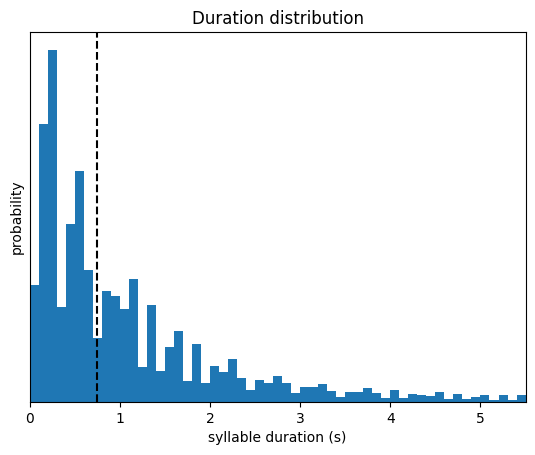

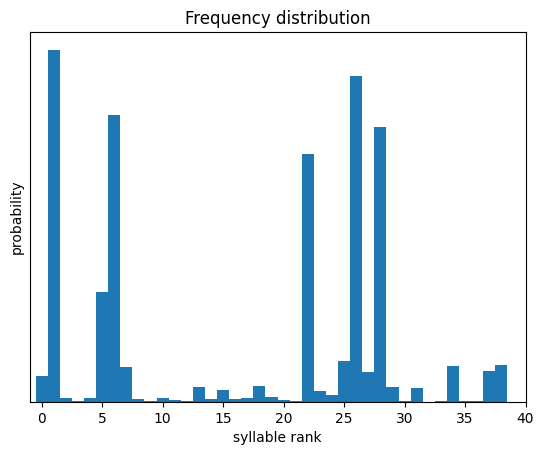

In [8]:
kpms.plot_duration_distribution(model_name=model_name, project_dir=project_dir, fps=fps, num_bins=50)
syllable_viz = 59  # syllable number to be visualized
#kpms.plot_syllable_frequencies(model_name=model_name, project_dir=project_dir, min_frequency = 0, syllable_viz = syllable_viz)
kpms.plot_syllable_frequencies(model_name=model_name, project_dir=project_dir, min_frequency = 0)

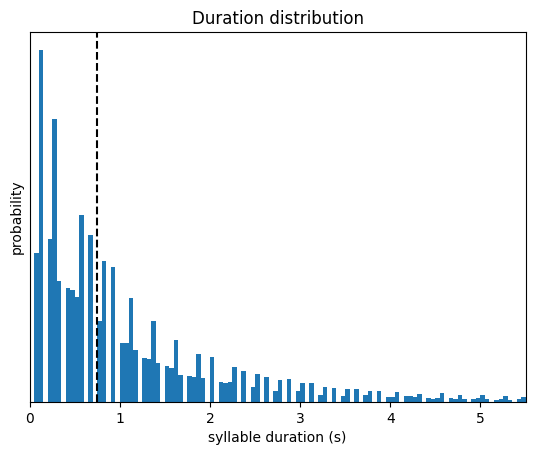

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def plot_duration_distribution(
    project_dir=None,
    model_name=None,
    results=None,
    path=None,
    lim=None,
    num_bins=30,
    fps=None,
    show_median=True,
):
    """Plot a histogram showing the frequency of each syllable.

    Caller must provide a results dictionary, a path to a results .h5, or a
    project directory and model name, in which case the results are loaded from
    `{project_dir}/{model_name}/results.h5`.

    Parameters
    ----------
    results : dict, default=None
        Dictionary containing modeling results for a dataset (see
        :py:func:`keypoint_moseq.fitting.extract_results`)

    model_name: str, default=None
        Name of the model. Required to load results if `results` is None and
        `path` is None.

    project_dir: str, default=None
        Project directory. Required to load results if `results` is None and
        `path` is None.

    path: str, default=None
        Path to a results file. If None, results will be loaded from
        `{project_dir}/{model_name}/results.h5`.

    lim: tuple, default=None
        x-axis limits as a pair of ints (in units of frames). If None, the
        limits are set to (0, 95th-percentile).

    num_bins: int, default=30
        Number of bins in the histogram.

    fps: int, default=None
        Frames per second. Used to convert x-axis from frames to seconds.

    show_median: bool, default=True
        Whether to show the median duration as a vertical line.

    Returns
    -------
    fig : matplotlib.figure.Figure
        Figure containing the histogram.

    ax : matplotlib.axes.Axes
        Axes containing the histogram.
    """
    if results is None:
        results = kpms.load_results(project_dir, model_name, path)

    syllables = {k: res["syllable"] for k, res in results.items()}
    durations = kpms.get_durations(syllables)

    if lim is None:
        lim = int(np.percentile(durations, 95))
    binsize = max(int(np.floor(lim / num_bins)), 1)

    if fps is not None:
        durations = durations / fps
        binsize = binsize / fps
        lim = lim / fps
        xlabel = "syllable duration (s)"
    else:
        xlabel = "syllable duration (frames)"

    fig, ax = plt.subplots()
    ax.hist(durations, range=(0, lim), bins=(int(lim / binsize)), density=True)
    ax.set_xlim([0, lim])
    ax.set_xlabel(xlabel)
    ax.set_ylabel("probability")
    ax.set_title("Duration distribution")
    ax.set_yticks([])
    if show_median:
        ax.axvline(np.median(durations), color="k", linestyle="--")
    return fig, ax, np.median(durations)



_, _, median_valussss = plot_duration_distribution(model_name=model_name, project_dir=project_dir, fps=fps, num_bins=1000)

## Grid movies
Generate video clips showing examples of each syllable.

In [9]:
#kpms.generate_grid_movies(results, project_dir, model_name, coordinates=coordinates, **config())

dataset = data_all_paths
coordinates, bodyparts = kpms.load_keypoints_AVATAR(dataset, path_in_name=False, remove_extension=True)

Loading keypoints: 100%|██████████| 77/77 [00:04<00:00, 15.92it/s]


In [10]:
SCALE_FACTOR = 10

results_rescaled = {}
for k,v in results.items():
    v_rescaled = dict(v)
    v_rescaled['centroid'] = v['centroid'] * SCALE_FACTOR
    results_rescaled[k] = v_rescaled

coordinates_rescaled = {}
for k,v in coordinates.items():
    v_rescaled = v * SCALE_FACTOR
    coordinates_rescaled[k] = v_rescaled

In [12]:
# for 3D data, include the flag `keypoints_only=True`
kpms.generate_grid_movies(results_rescaled, project_dir=project_dir, model_name=model_name, coordinates=coordinates_rescaled, min_frequency=0.005,filter_size = 6,
                        keypoints_only=True, fps=fps, use_dims=[0,2], pre=40, post=60, rows=3, cols=4, window_size=16*14, **config())

Writing grid movies to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\AmD\dataset2\2024_06_16-01_26_57\grid_movies


Generating grid movies: 100%|███████████| 19/19 [01:47<00:00,  5.68s/it]


{2: [('wt_s3d61_321', 7123, 7130),
  ('ko_s1d54_122', 11660, 11666),
  ('ko_s1d68_131', 10796, 10800),
  ('ko_s1d61_122', 10229, 10235),
  ('ko_s1d61_141', 11140, 11146),
  ('ko_s1d68_141', 8900, 8904),
  ('ko_s1d58_122', 9437, 9442),
  ('ko_s1d65_131', 10123, 10127),
  ('ko_s1d68_113', 4127, 4132),
  ('ko_s1d68_122', 1445, 1450),
  ('wt_s3d54_311', 1847, 1852),
  ('ko_s3d50_322', 9347, 9352)],
 6: [('ko_s1d54_123', 8730, 8764),
  ('ko_s3d57_322', 1409, 1414),
  ('wt_s1d54_151', 3693, 3698),
  ('wt_s3d64_331', 10701, 10705),
  ('wt_s3d64_321', 5820, 5832),
  ('ko_s3d50_336', 4702, 4716),
  ('ko_s1d65_123', 438, 481),
  ('wt_s3d64_313', 11088, 11113),
  ('wt_s3d57_331', 1560, 1602),
  ('wt_s1d58_152', 3847, 3855),
  ('ko_s1d54_112', 10592, 10603),
  ('ko_s1d65_131', 8444, 8447)],
 12: [('ko_s3d57_324', 10597, 10630),
  ('wt_s3d54_331', 4149, 4433),
  ('wt_s3d50_313', 9107, 9196),
  ('ko_s3d57_323', 1943, 1999),
  ('ko_s3d50_323', 9360, 9399),
  ('wt_s3d57_337', 222, 267),
  ('wt_s1d61_1

## Syllable Dendrogram
Plot a dendrogram representing distances between each syllable's median trajectory.

Saving dendrogram plot to H:\공유 드라이브\Broad X ACTNOVA\kp-moseq\trial2_without_nose_tip\2024_03_27-21_14_34\similarity_dendrogram


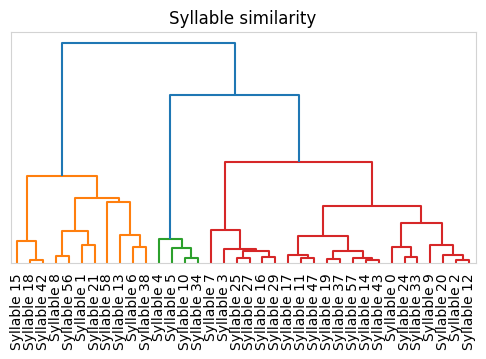

In [37]:
kpms.plot_similarity_dendrogram(coordinates, results, project_dir, model_name, min_frequency=0.005, **config())